In [34]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras

In [24]:
path="animals/animals"
data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      
print(data["labels"])
df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

['antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger',

In [25]:
df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

In [26]:
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)


----------Train-------------
                                       imgpath        labels
0           animals/animals\owl\4ee4d30847.jpg           owl
1   animals/animals\caterpillar\89eeb3fb5a.jpg   caterpillar
2  animals/animals\hippopotamus\5bbec0931a.jpg  hippopotamus
3           animals/animals\bee\1cb123c4e9.jpg           bee
4          animals/animals\hare\83ede67a4d.jpg          hare
(3779, 3)
--------Validation----------
                                imgpath labels
0    animals/animals\fly\42b0f4b756.jpg    fly
1    animals/animals\owl\19b344e001.jpg    owl
2  animals/animals\sheep\1e55e3f2de.jpg  sheep
3    animals/animals\pig\76a897226f.jpg    pig
4  animals/animals\eagle\6f634d9a5f.jpg  eagle
(1134, 3)
----------Test--------------
                                     imgpath      labels
0       animals/animals\snake\68fa005f8c.jpg       snake
1  animals/animals\woodpecker\41bfce3808.jpg  woodpecker
2        animals/animals\boar\0b2e935388.jpg        boar
3      animals/an

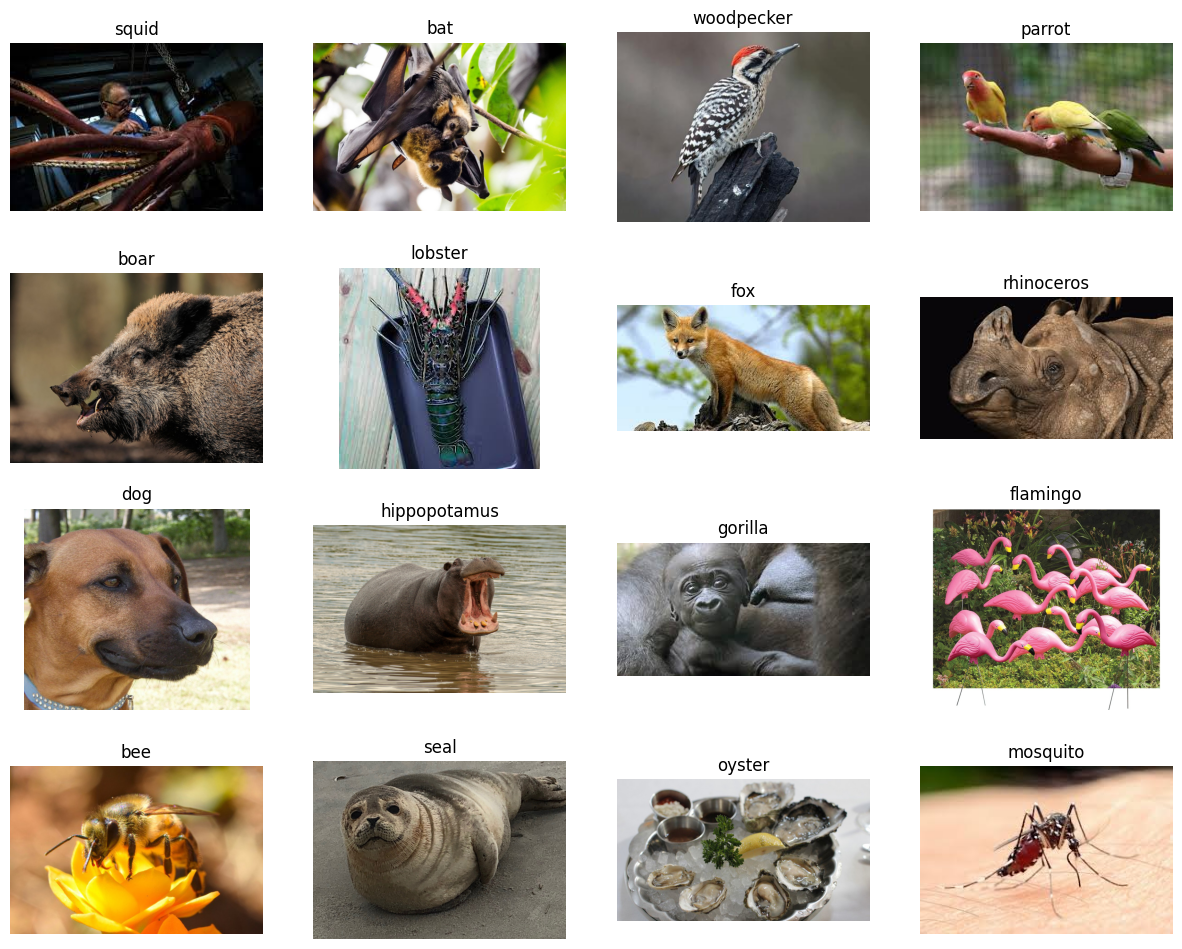

In [31]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [35]:
BATCH_SIZE = 15
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)
# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)
val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 3779 validated image filenames belonging to 90 classes.
Found 487 validated image filenames belonging to 90 classes.
Found 1134 validated image filenames belonging to 90 classes.
